# LSTM to learn the dynamics of the Lorenz system
In this session, we will use what you learned about recurrent neural network to design a neural network that can learn the dynamics of a chaotic system (derived from atmospheric flow) called the Lorenz system.

The equations of the Lorenz system are given by:
    \begin{equation}
    \frac{dx}{dt} = \sigma (y-x), \hspace{11pt} \frac{dy}{dt} = x(\rho-z) - y, \hspace{11pt}, \frac{dz}{dt}=xy-\beta z
    \end{equation}

Typical values for the parameters are $\sigma=10$ and $\beta = 8/3$.

In [ ]:
use_colab = True
if use_colab:
    !git clone -b main https://github.com/adoanTUD/CYPHER_MLSchool.git

    # from google.colab import drive
    # drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1 Loading librairies

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf

# 2 Load dataset

In [ ]:
if use_colab:
    fld = './CYPHER_MLSchool/'
else:
    fld = './'
np_file = np.load( fld + 'Lorenz_data/LorenzSys_Lorenz_data.npz')
X = np_file['X'] # Data
dt = np_file['dt']
t_split = np_file['t_stop_train']
t_skip = np_file['t_skip']
val_ratio = np_file['val_ratio']
Lyap = np_file['Lyap']

# remove the transient from the dataset
i_skip = int(t_skip/dt)
X = X[i_skip:,:]

In [ ]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot(X[:,0],X[:,1],X[:,2])

<IPython.core.display.Javascript object>

In [ ]:
plt.figure()
plt.plot(X[0:1000,0])
plt.plot(X[0:1000,1])
plt.plot(X[0:1000,2])

<IPython.core.display.Javascript object>

# 3 Dataset preparation
We now need to define the problem that we try to solve, meaning what is the purpose of our neural network.

Here we will try to develop the neural network so that it can reproduce autonomously the dynamics of the Lorenz system. That means that the input of the neural network will be the $N_{step}$ states in the past, $[\underline{x}(t-N_{step}),...,\underline{x}(t-1)]$, and it has to predict the next state at time $t$, $\underline{x}(t)$.

This allows us to define our training dataset.

In [ ]:
# Dataset normalization
Xmean = np.mean(X,0)
Xstd = np.std(X,0)
X = X - np.mean(X,0)
X = X/np.std(X,0)

In [ ]:
# we define the input/output split
input_all = X[:-1,:]
output_all = X[1:,:]

# we further split the entire dataset into
# training/validation/test dataset
val_ratio = 0.75
test_ratio = 0.9
idx_val = int(np.round(val_ratio*len(input_all)))
idx_test = int(np.round(test_ratio*len(input_all)))

input_train = input_all[:idx_val,:]
output_train = output_all[:idx_val,:]

input_val = input_all[idx_val:idx_test,:]
output_val = output_all[idx_val:idx_test,:]

input_test = input_all[idx_test:,:]
output_test = output_all[idx_test:,:]

We now need to further reorganize the dataset so that for an input composed of $N_{step}$ timesteps, corresponds the output at time $t$.

In [ ]:
Nstep = 10

#reshape the data
inn = []
for i in range(input_train.shape[0]-Nstep):
    inn.append(input_train[i:i+Nstep,:])
input_train = np.array(inn)
output_train = output_train[Nstep-1:-1,:]

inn = []
for i in range(input_val.shape[0]-Nstep):
    inn.append(input_val[i:i+Nstep,:])
input_val = np.array(inn)
output_val = output_val[Nstep-1:-1,:]

In [ ]:
print(output_train.shape)

(84365, 3)


# 4. Definition of our neural network
We now define our neural network

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(20,input_shape=(Nstep,3),return_sequences=True))
model.add(tf.keras.layers.LSTM(20))
model.add(tf.keras.layers.Dense(3,activation='linear'))

model.compile(optimizer='adam',loss='mse')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 20)              │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │              63 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,263 (20.56 KB)

 Trainable params: 5,263 (20.56 KB)

 Non-trainable params: 0 (0.00 B)

# 5. Training of the neural network


In [ ]:
checkpoint_filepath = fld + './checkpoint_LSTM_Lorenz.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


In [ ]:
nb_epochs = 100

history = model.fit(input_train, output_train, validation_data=(input_val, output_val),
                    epochs=nb_epochs, verbose=1, callbacks=[model_checkpoint_callback,early_stop_callback])

model.load_weights(checkpoint_filepath)

Epoch 1/100
2637/2637 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.0734 - val_loss: 5.4798e-05
Epoch 2/100
2637/2637 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 3.9410e-05 - val_loss: 3.6079e-05
Epoch 3/100
2637/2637 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 5.2014e-05 - val_loss: 1.4113e-05
Epoch 4/100
2637/2637 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 4.1284e-05 - val_loss: 4.7349e-05
Epoch 5/100
2637/2637 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 4.5633e-05 - val_loss: 1.4790e-05
Epoch 6/100
2637/2637 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 3.1581e-05 - val_loss: 3.5600e-05


# 6. Visualization of the prediction from the neural network


In [ ]:
x_ref = X[idx_test:,:]
print(x_ref.shape)
x_ref = x_ref[:1000,:]

(11251, 3)


In [ ]:
# We look at the natural response of the neural network
Y = []
y_last = x_ref[0:Nstep, :].reshape((1, Nstep, 3))
print('start natural response')
for i in range(x_ref.shape[0] - Nstep):
    Y.append(model.predict(y_last, verbose=0))
    y_last = np.append(y_last, Y[i].reshape(1, 1, 3), axis=1)
    y_last = y_last[:, 1:, :]
    if (i%50==0):
        print('%d prediction done' % (i + 1))

start natural response
1 prediction done
51 prediction done
101 prediction done
151 prediction done
201 prediction done
251 prediction done
301 prediction done
351 prediction done
401 prediction done
451 prediction done
501 prediction done
551 prediction done
601 prediction done
651 prediction done
701 prediction done
751 prediction done
801 prediction done
851 prediction done
901 prediction done
951 prediction done


In [ ]:
Y = np.array(Y)
print(Y.shape)
Y = Y.reshape(Y.shape[0], Y.shape[2])
Y = np.vstack((x_ref[:Nstep, :], Y))

(990, 1, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

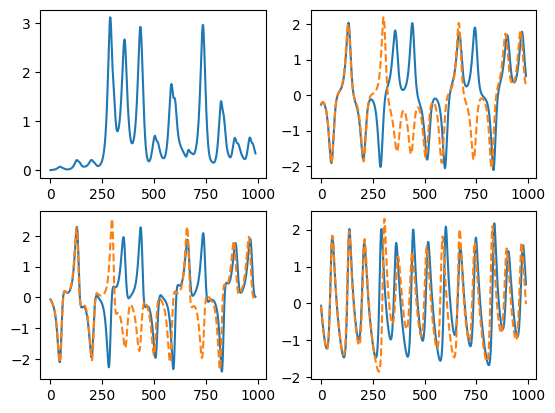

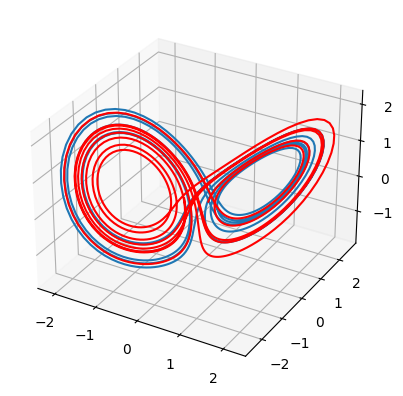

In [ ]:
# calculate Error
err = np.linalg.norm(Y[Nstep:, :] - x_ref[Nstep:, :], axis=1) / np.sqrt(
    np.average(np.square(np.linalg.norm(x_ref[Nstep:, :], axis=1))))

%matplotlib inline
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(err)

ax2 = fig.add_subplot(222)
ax2.plot(x_ref[Nstep:, 0])
ax2.plot(Y[Nstep:, 0], '--')

ax3 = fig.add_subplot(223)
ax3.plot(x_ref[Nstep:, 1])
ax3.plot(Y[Nstep:, 1], '--')

ax4 = fig.add_subplot(224)
ax4.plot(x_ref[Nstep:, 2])
ax4.plot(Y[Nstep:, 2], '--')

fig2 = plt.figure()
ax3d = fig2.add_subplot(111,projection='3d')
ax3d.plot(x_ref[Nstep:,0],x_ref[Nstep:,1],x_ref[Nstep:,2])
ax3d.plot(Y[Nstep:,0],Y[Nstep:,1],Y[Nstep:,2],'r')
